<a href="https://colab.research.google.com/github/thiagocvrocha/trabalho_estocasticos/blob/main/TrabFinalEstocasticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARREGA O .CSV DO GOOGLE DRIVE, PLOTA HISTOGRMA E APLICA O TESTE KS:

Mounted at /content/drive
Nó (Node ID): 5599
Modulação: FSK

Parâmetros da Distribuição Normal:
   Média (μ): -91.86 dBm
   Variância (σ²): 30.63 dBm²
   Desvio Padrão (σ): 5.53 dBm

   P-valor do teste: 0.0000

   Conclusão: O teste sugere que os dados não seguem uma distribuição normal perfeita.


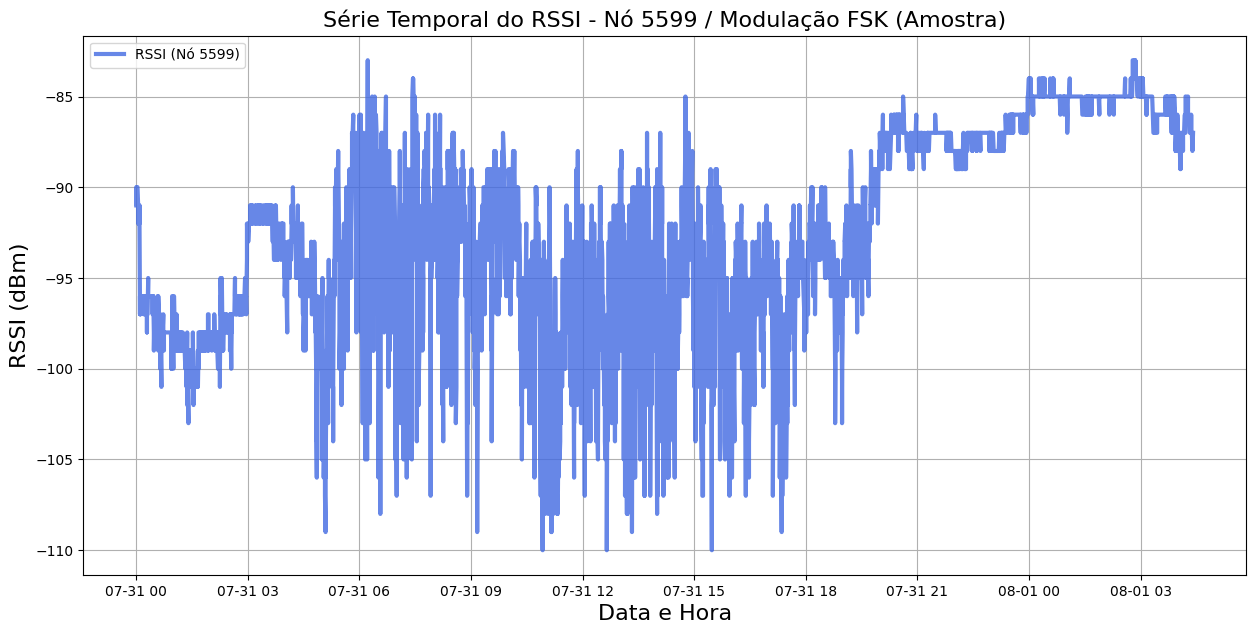

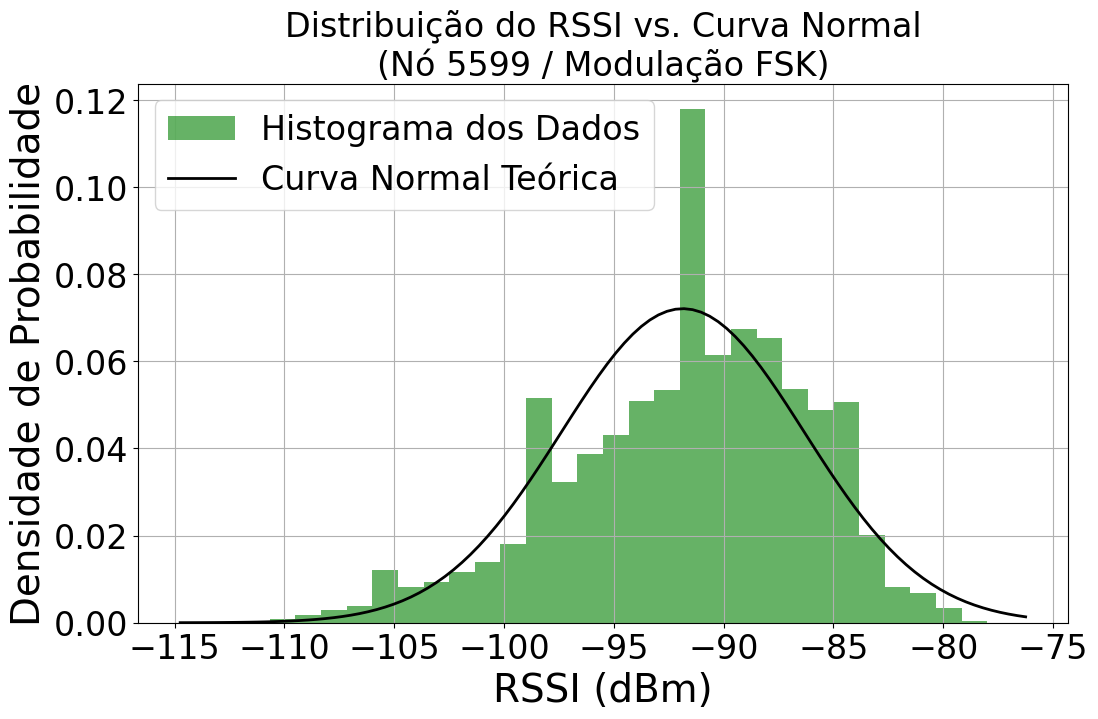

In [14]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Conectar ao Google Drive e definir o caminho do arquivo
try:
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/MyDrive/Colab_Datasets/data_5599.csv'
    # Tenta carregar o arquivo para garantir que o caminho está correto
    df_full = pd.read_csv(file_path)
except Exception as e:
    print(f"Ocorreu um erro ao acessar o arquivo: {e}")

# Processar os dados
# Adiciona a coluna com o ID do nó
df_full['node_id'] = '5599'

# Converte as colunas 'day' e 'hour' para um único objeto datetime
df_full['datetime'] = pd.to_datetime(df_full['day'] + ' ' + df_full['hour'], errors='coerce')

id_vars = ['datetime', 'pkt_number', 'pkt_retry', 'node_id']
value_vars_rssi = ['fsk_rssi', 'oqpsk_rssi', 'ofdm_rssi']

df_processed = df_full.melt(
    id_vars=id_vars,
    value_vars=value_vars_rssi,
    var_name='modulation',
    value_name='rssi'
)

# Limpa o nome da modulação (ex: 'fsk_rssi' se torna 'fsk')
df_processed['modulation'] = df_processed['modulation'].str.replace('_rssi', '')

node_to_analyze = '5599'
modulation_to_analyze = 'fsk'

df_case_study = df_processed[
    (df_processed['node_id'] == node_to_analyze) &
    (df_processed['modulation'] == modulation_to_analyze)
].copy()

df_case_study.dropna(subset=['rssi', 'datetime'], inplace=True)
df_case_study.sort_values('datetime', inplace=True)

rssi_data = df_case_study['rssi']
rssi_mean = rssi_data.mean()
rssi_var = rssi_data.var()
rssi_std = rssi_data.std()
print(f"Nó (Node ID): {node_to_analyze}")
print(f"Modulação: {modulation_to_analyze.upper()}\n")
print("Parâmetros da Distribuição Normal:")
print(f"   Média (μ): {rssi_mean:.2f} dBm")
print(f"   Variância (σ²): {rssi_var:.2f} dBm²")
print(f"   Desvio Padrão (σ): {rssi_std:.2f} dBm\n")

# Validação estatística
standardized_rssi = (rssi_data - rssi_mean) / rssi_std
ks_statistic, p_value = stats.kstest(standardized_rssi, 'norm')
print(f"   P-valor do teste: {p_value:.4f}")
if p_value > 0.05:
    print("\n   Conclusão: O teste confirma a distribuição Normal.")
else:
    print("\n   Conclusão: O teste sugere que os dados não seguem uma distribuição normal perfeita.")

# Gráfico: Série Temporal do RSSI
plt.figure(figsize=(15, 7))
plt.plot(df_case_study['datetime'].head(5000), df_case_study['rssi'].head(5000), label=f'RSSI (Nó {node_to_analyze})', color='royalblue', alpha=0.8)
plt.title(f'Série Temporal do RSSI - Nó {node_to_analyze} / Modulação {modulation_to_analyze.upper()} (Amostra)', fontsize=16)
plt.xlabel('Data e Hora', fontsize=16)
plt.ylabel('RSSI (dBm)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


# Histograma e Curva da Distribuição Normal
plt.figure(figsize=(12, 7))
plt.hist(rssi_data, bins=30, density=True, alpha=0.6, color='g', label='Histograma dos Dados')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, rssi_mean, rssi_std)
plt.plot(x, p, 'k', linewidth=2, label='Curva Normal Teórica')

title = f'Distribuição do RSSI vs. Curva Normal\n(Nó {node_to_analyze} / Modulação {modulation_to_analyze.upper()})'

plt.title(title, fontsize=24)
plt.xlabel('RSSI (dBm)', fontsize=28)
plt.ylabel('Densidade de Probabilidade', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.grid(True)
plt.show()

# MODELANDO COMO PROCESSO ESTOCÁSTICO:

Verificação de estacionariedade (ADF - Augmented Dickey-Fuller) - aplicado a uma amostra dos dados devido a probemas de memória

In [15]:
from statsmodels.tsa.stattools import adfuller

# Extrai a série de dados de RSSI
rssi_data = df_case_study['rssi']

# SOLUÇÃO PARA O ERRO DE RAM
# Como a série completa é muito grande, peguei uma amostra aleatória representativa para o teste
# Usei 'random_state=42' para garantir que a amostra seja sempre a mesma, tornando o resultado reprodutível
data_sample_for_test = rssi_data.sample(n=50000, random_state=42)

# Realiza o teste ADF na AMOSTRA de dados
adf_test_result = adfuller(data_sample_for_test)
print(f'Estatística ADF: {adf_test_result[0]:.4f}')
print(f'P-valor: {adf_test_result[1]:.4f}')
print('Valores Críticos:')
for key, value in adf_test_result[4].items():
    print(f'\t{key}: {value:.4f}')

if adf_test_result[1] <= 0.05:
    print("\nConclusão: P-valor <= 0.05. Rejeita-se a hipótese nula.")
    print("A série temporal é ESTACIONÁRIA. Pode-se usar um modelo ARMA(p,q).")
else:
    print("\nConclusão: P-valor > 0.05. Não podemos rejeitar a hipótese nula.")
    print("A série temporal NÃO é estacionária. Seria necessário diferenciar (usar ARIMA).")

Estatística ADF: -223.9647
P-valor: 0.0000
Valores Críticos:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668

Conclusão: P-valor <= 0.05. Rejeita-se a hipótese nula.
A série temporal é ESTACIONÁRIA. Pode-se usar um modelo ARMA(p,q).


# Verificando a representatividade da série amostrada com a série original:

--- Comparação das Estatísticas: Série Original vs. Amostra Aleatória ---
  Métrica  Série Original (332,012 pontos)  Amostra Aleatória (50,000 pontos)
    Média                       -91.859957                         -91.830620
Variância                        30.625909                          30.579982


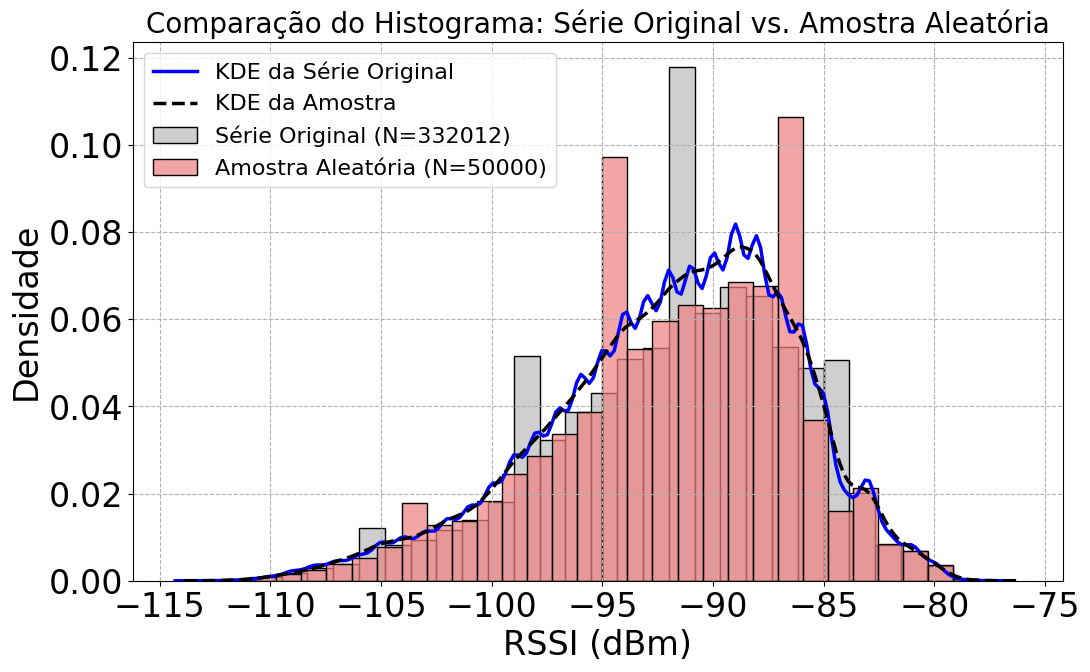

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calcula estatísticas da série original
mean_original = rssi_data.mean()
var_original = rssi_data.var()

# Cria a amostra aleatória
n_amostra = 50000
amostra_aleatoria = rssi_data.sample(n=n_amostra, random_state=42)

# Calcula as estatísticas da amostra
mean_amostra = amostra_aleatoria.mean()
var_amostra = amostra_aleatoria.var()

# Apresenta a tabela comparativa
print("--- Comparação das Estatísticas: Série Original vs. Amostra Aleatória ---")
comparison_data = {
    "Métrica": ["Média", "Variância"],
    "Série Original (332,012 pontos)": [mean_original, var_original],
    "Amostra Aleatória (50,000 pontos)": [mean_amostra, var_amostra]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Plot
plt.figure(figsize=(12, 7))

# Série original
sns.histplot(rssi_data, stat='density', bins=30, color='silver',
             label=f'Série Original (N={len(rssi_data)})', kde=False) # kde=False
sns.kdeplot(rssi_data, color='blue', linewidth=2.5, label='KDE da Série Original')

# Amostra aleatória
sns.histplot(amostra_aleatoria, stat='density', bins=30, color='lightcoral',
             alpha=0.7, label=f'Amostra Aleatória (N={n_amostra})', kde=False) # kde=False
sns.kdeplot(amostra_aleatoria, color='black', linewidth=2.5, linestyle='--', label='KDE da Amostra')

plt.title('Comparação do Histograma: Série Original vs. Amostra Aleatória', fontsize=20)
plt.xlabel('RSSI (dBm)', fontsize=24)
plt.ylabel('Densidade', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--')
plt.show()

# Análise de autocorrelação (identificação do modelo):

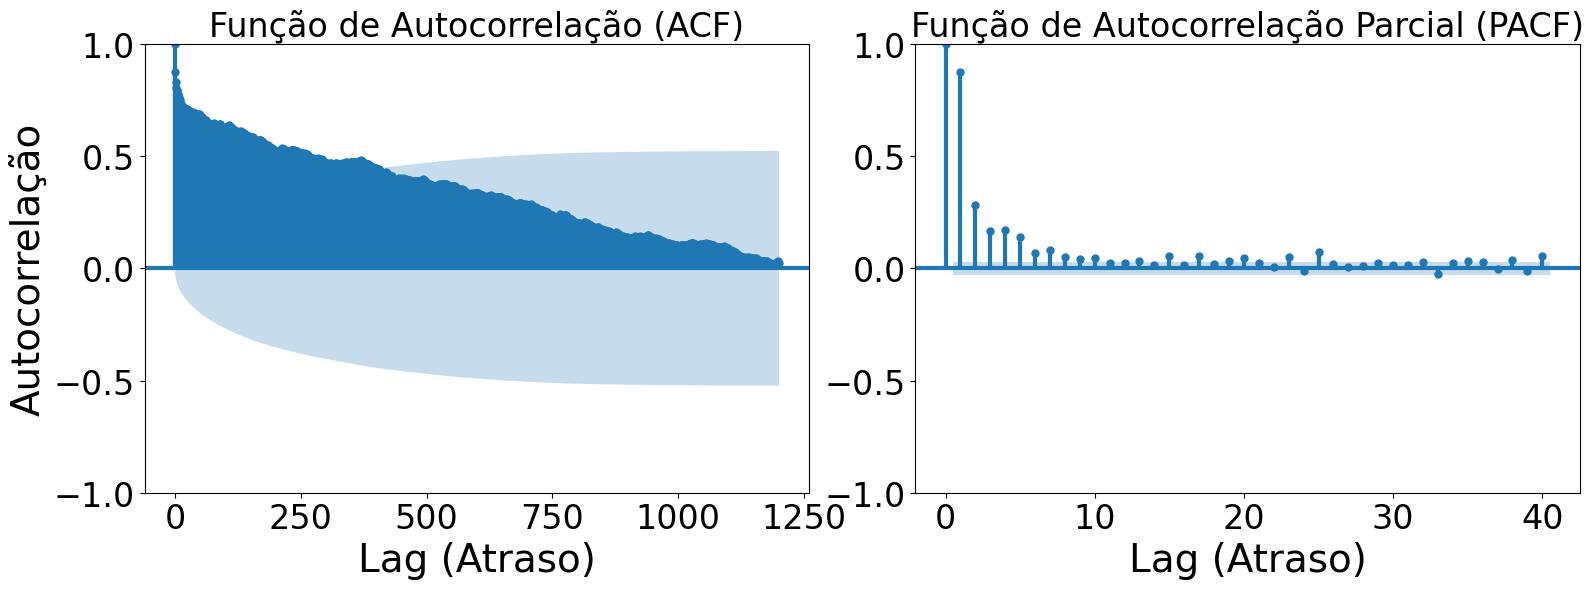

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

data_sample = rssi_data.head(5000)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Gráfico da ACF
plot_acf(data_sample, ax=axes[0], lags=1200)

# Aumenta o tamanho das fontes
axes[0].set_title('Função de Autocorrelação (ACF)', fontsize=24)
axes[0].set_xlabel('Lag (Atraso)', fontsize=28)
axes[0].set_ylabel('Autocorrelação', fontsize=28)
axes[0].tick_params(axis='both', which='major', labelsize=24)

# Gráfico da PACF
plot_pacf(data_sample, ax=axes[1], lags=40)

# Aumenta o tamanho das fontes
axes[1].set_title('Função de Autocorrelação Parcial (PACF)', fontsize=24)
axes[1].set_xlabel('Lag (Atraso)', fontsize=28)
axes[1].tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

# Ajuste (fit) do Modelo ARMA:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(rssi_data, order=(8, 0, 0)) # Testado  de (1,0,0) até (8,0,0), quando p-valor atendeu
results = model.fit()

print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   rssi   No. Observations:               332012
Model:                 ARIMA(8, 0, 0)   Log Likelihood             -754251.734
Date:                Fri, 15 Aug 2025   AIC                        1508523.468
Time:                        18:57:12   BIC                        1508630.597
Sample:                             0   HQIC                       1508554.320
                             - 332012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -91.8600      0.141   -649.740      0.000     -92.137     -91.583
ar.L1          0.5138      0.001    457.911      0.000       0.512       0.516
ar.L2          0.1393      0.001    110.291      0.0

# Diagnóstico final:

Mounted at /content/drive

  Analisando Modelo AR(1) / ARIMA(1, 0, 0)

--- Métricas de Avaliação ---
AIC: 1565527.09
BIC: 1565559.22
--- Gráfico de Diagnóstico para AR(1) ---


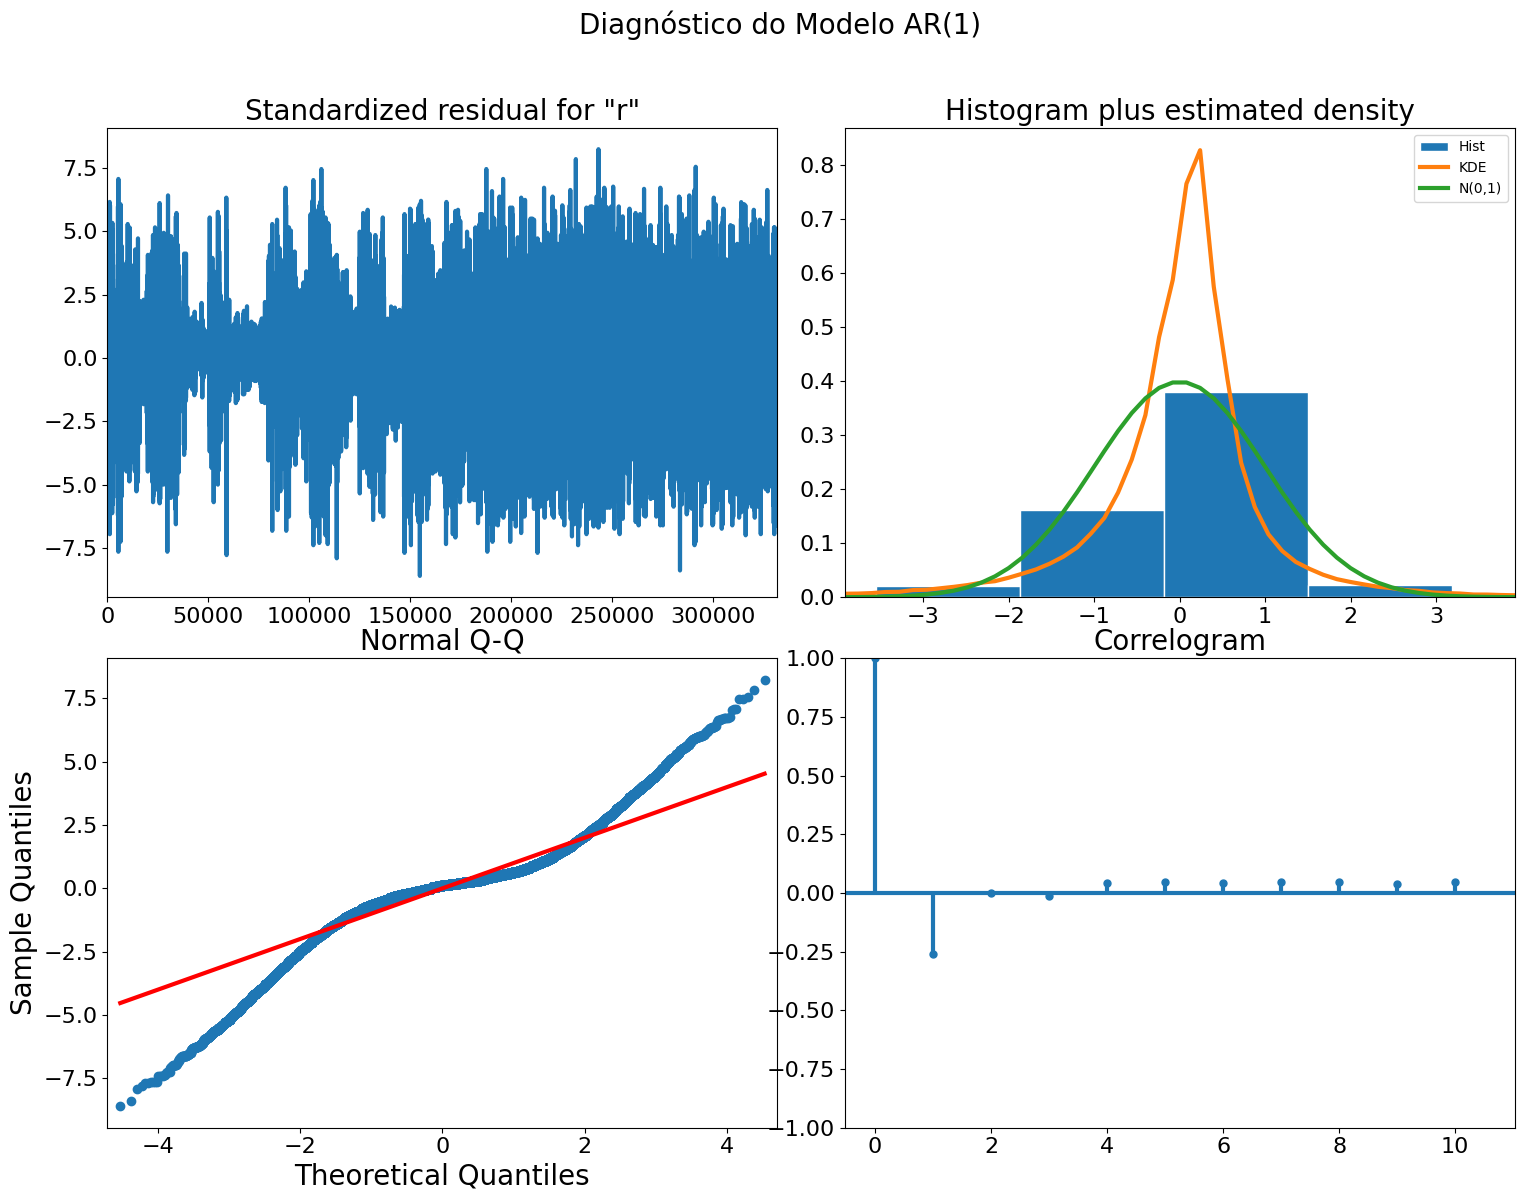


  Analisando Modelo AR(2) / ARIMA(2, 0, 0)

--- Métricas de Avaliação ---
AIC: 1535241.09
BIC: 1535283.94
--- Gráfico de Diagnóstico para AR(2) ---


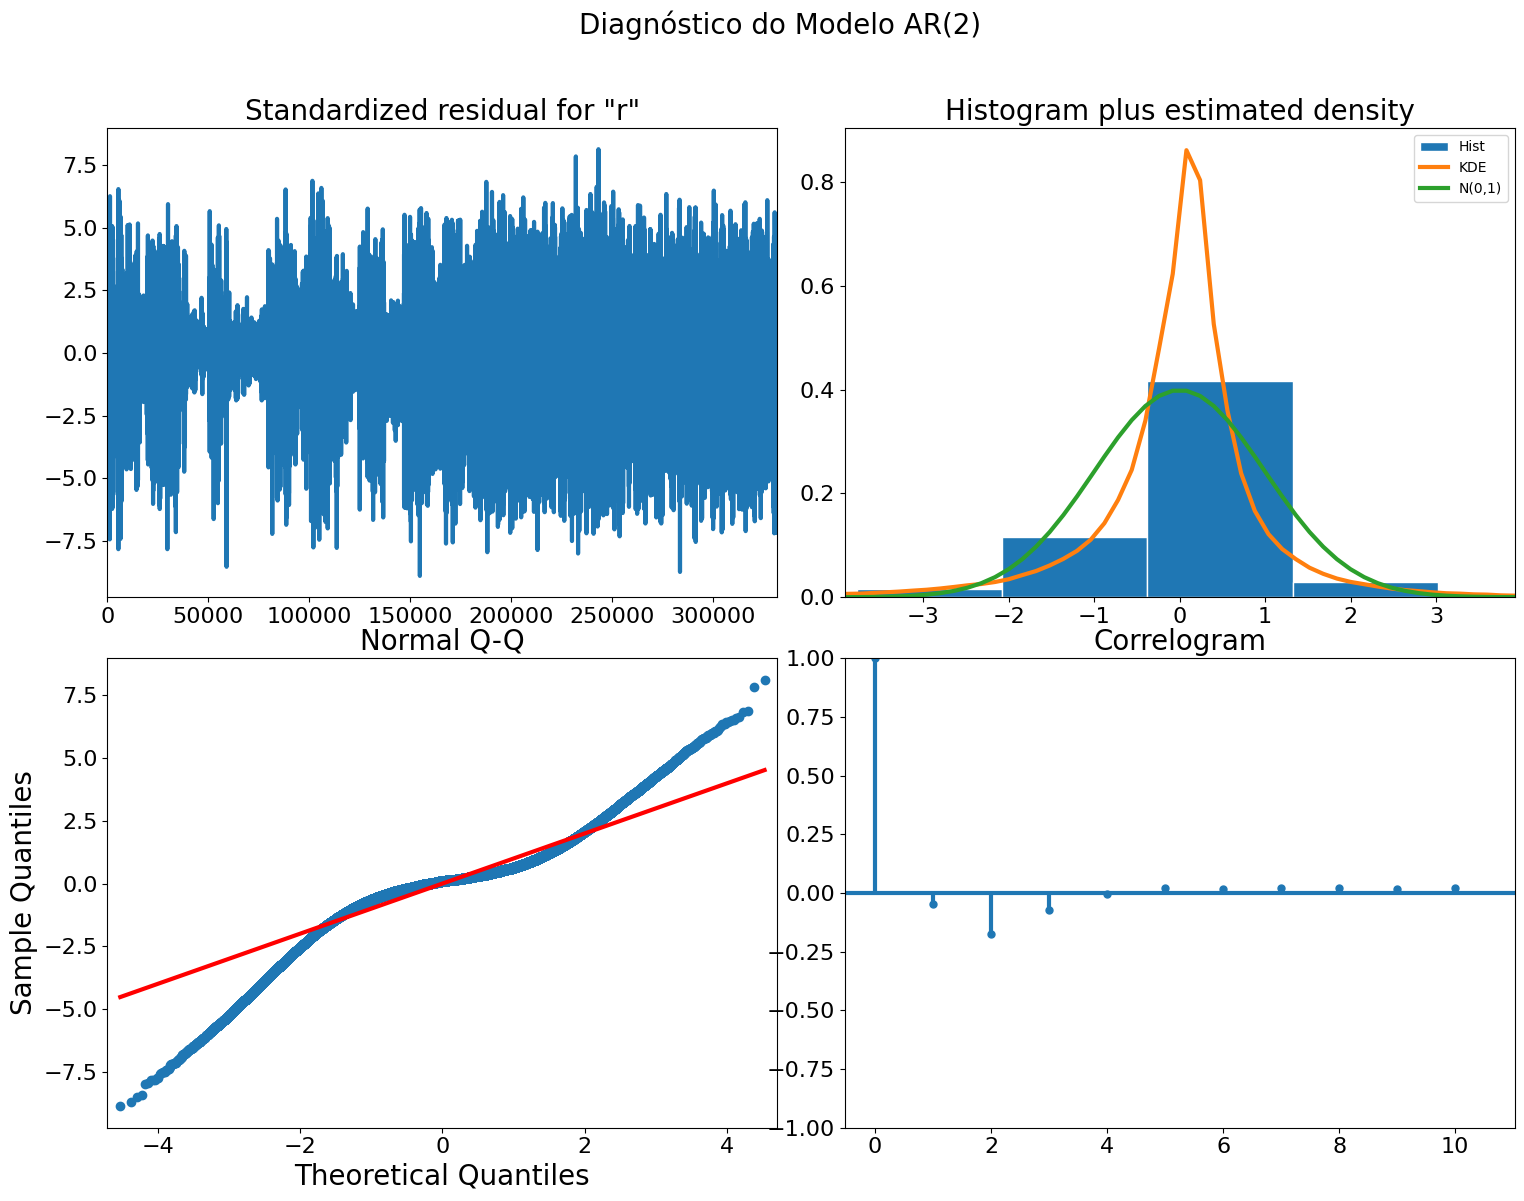


  Analisando Modelo AR(3) / ARIMA(3, 0, 0)

--- Métricas de Avaliação ---
AIC: 1526292.93
BIC: 1526346.49
--- Gráfico de Diagnóstico para AR(3) ---


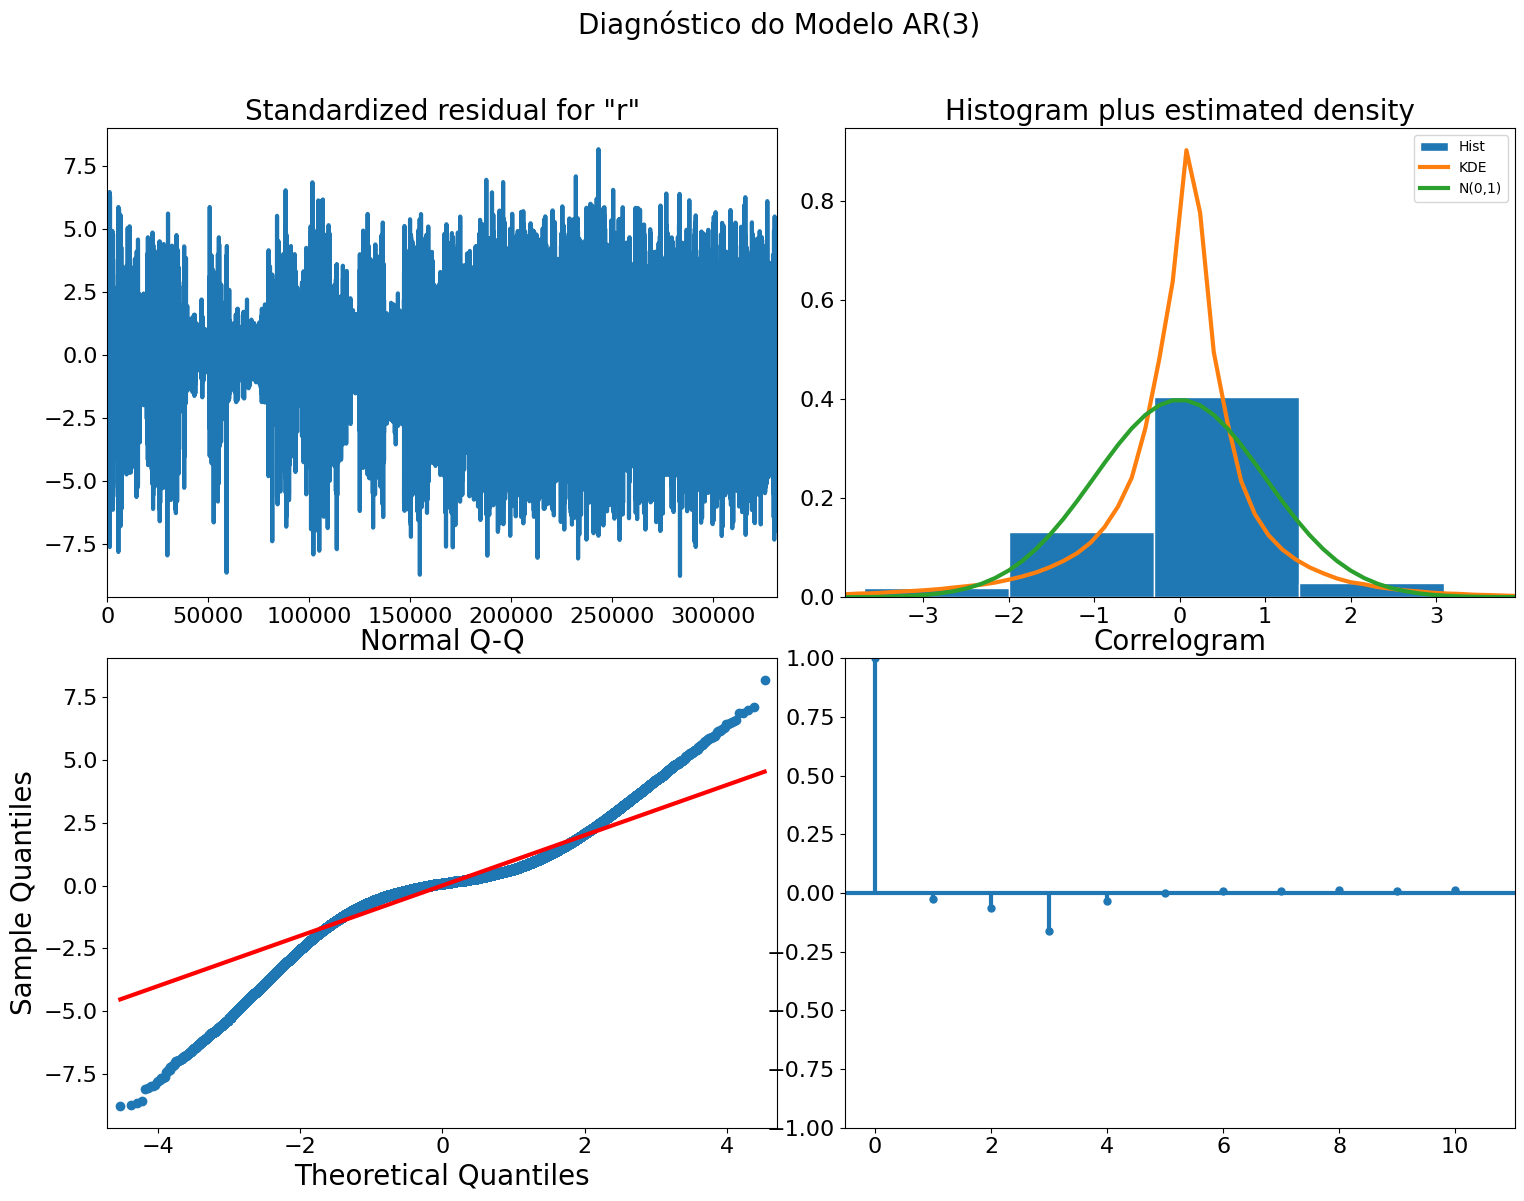


  Analisando Modelo AR(4) / ARIMA(4, 0, 0)

--- Métricas de Avaliação ---
AIC: 1518087.48
BIC: 1518151.76
--- Gráfico de Diagnóstico para AR(4) ---


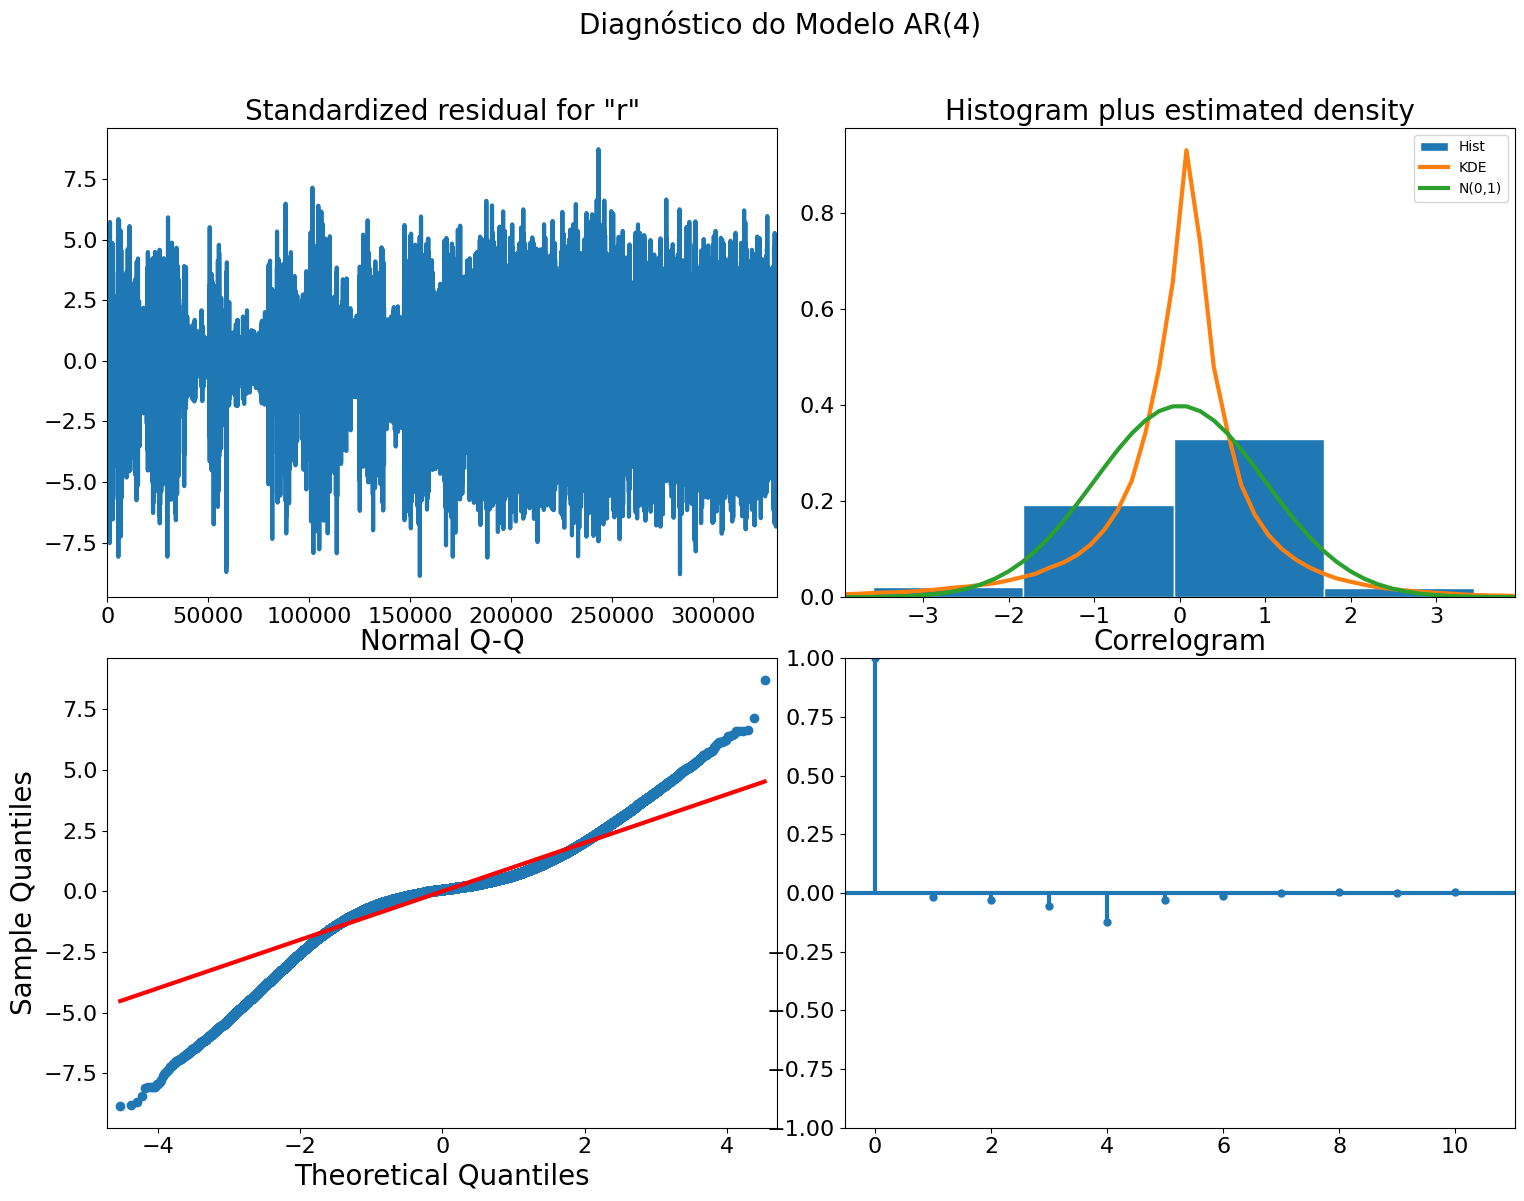


  Analisando Modelo AR(5) / ARIMA(5, 0, 0)

--- Métricas de Avaliação ---
AIC: 1513737.75
BIC: 1513812.74
--- Gráfico de Diagnóstico para AR(5) ---


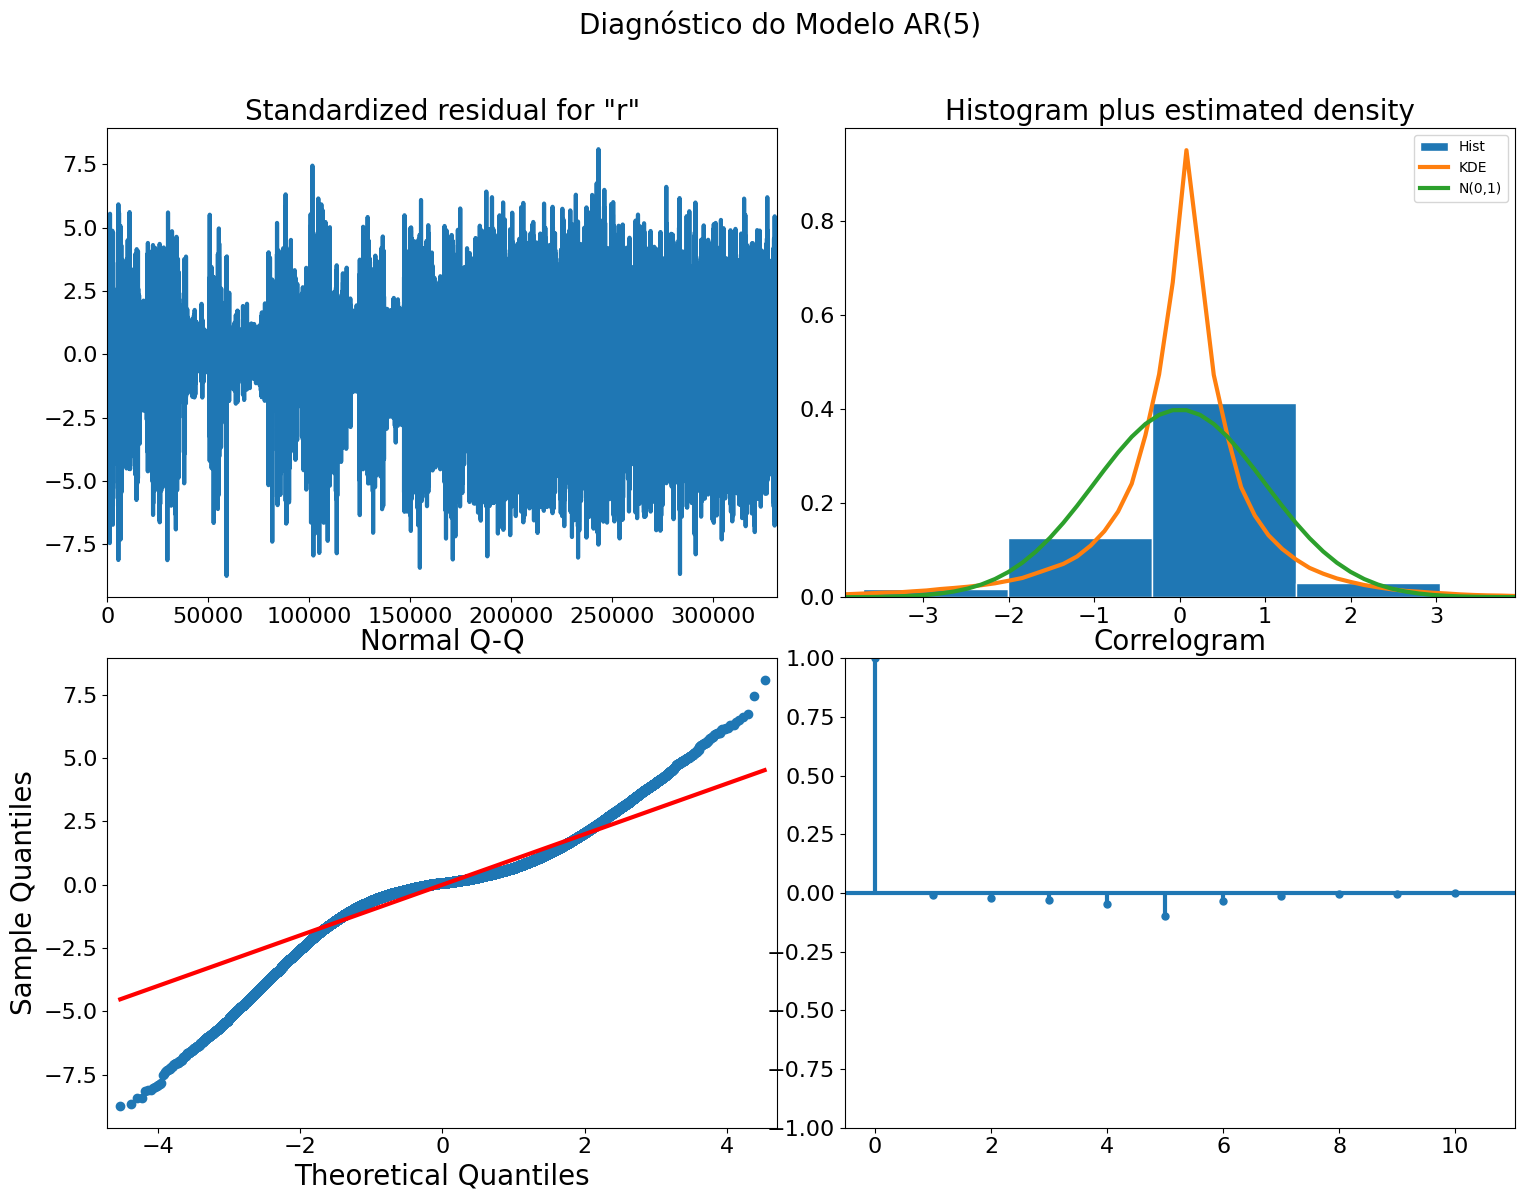


  Analisando Modelo AR(6) / ARIMA(6, 0, 0)

--- Métricas de Avaliação ---
AIC: 1511449.36
BIC: 1511535.07
--- Gráfico de Diagnóstico para AR(6) ---


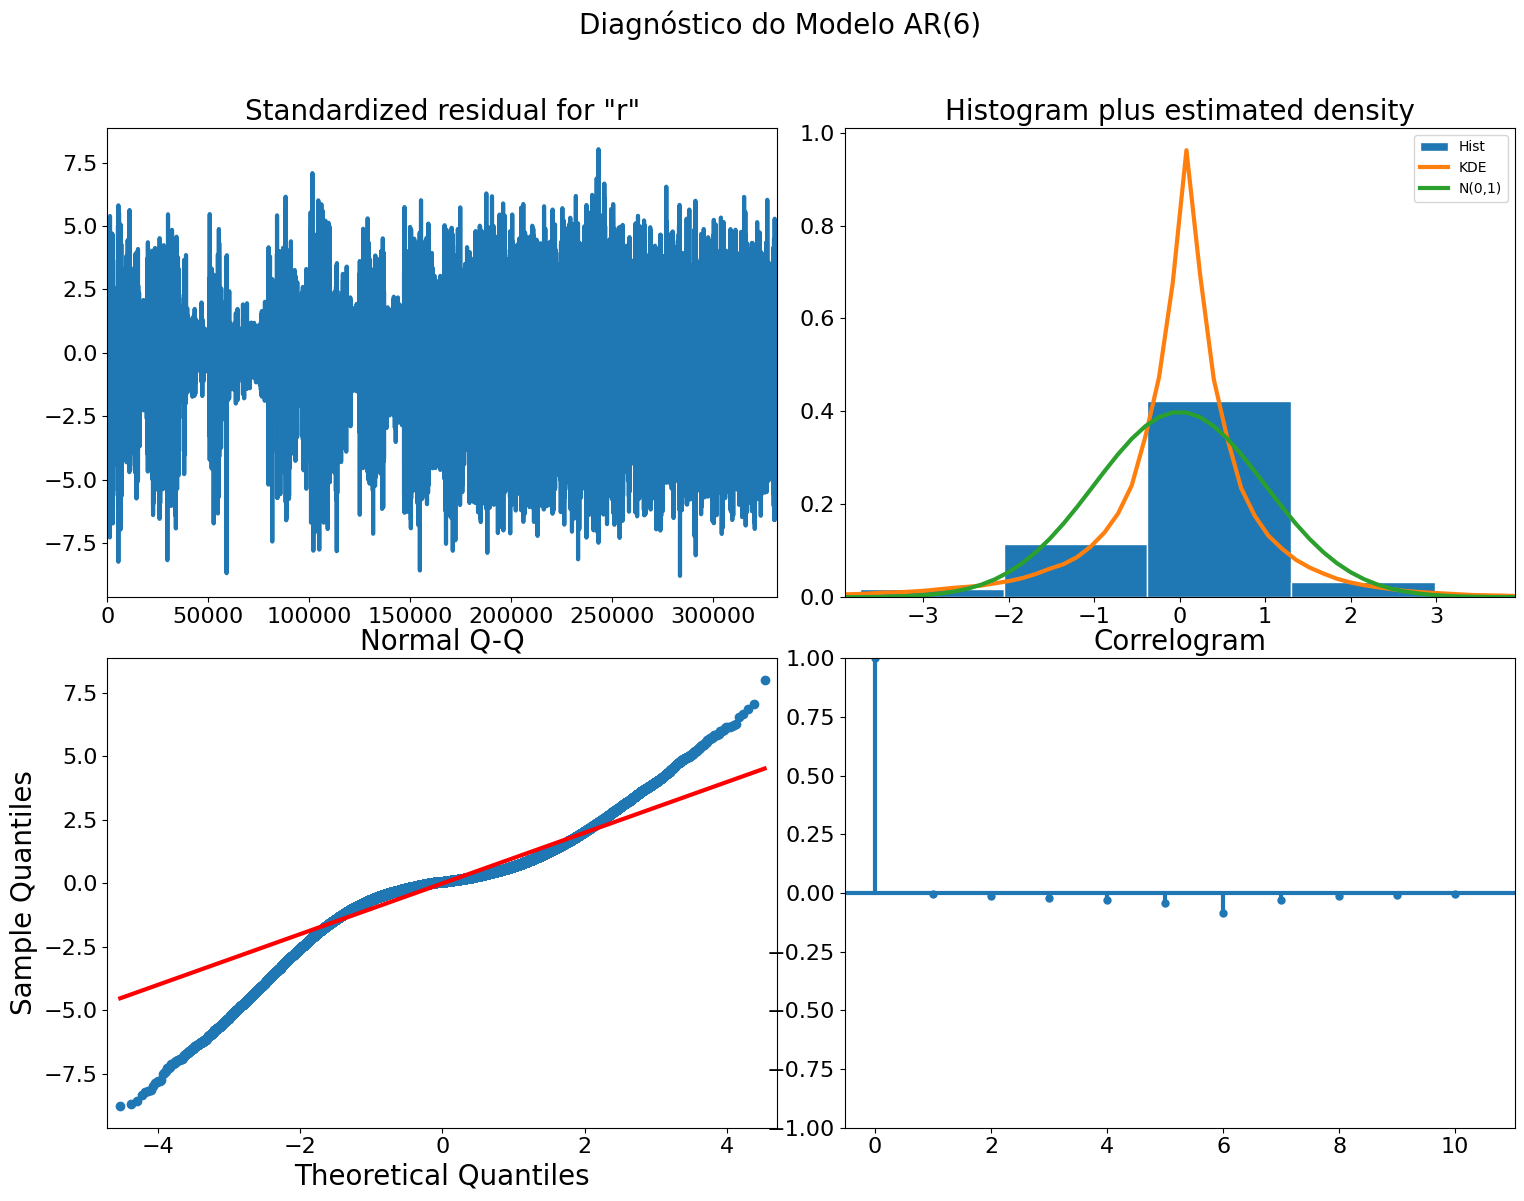


  Analisando Modelo AR(7) / ARIMA(7, 0, 0)

--- Métricas de Avaliação ---
AIC: 1509709.64
BIC: 1509806.06
--- Gráfico de Diagnóstico para AR(7) ---


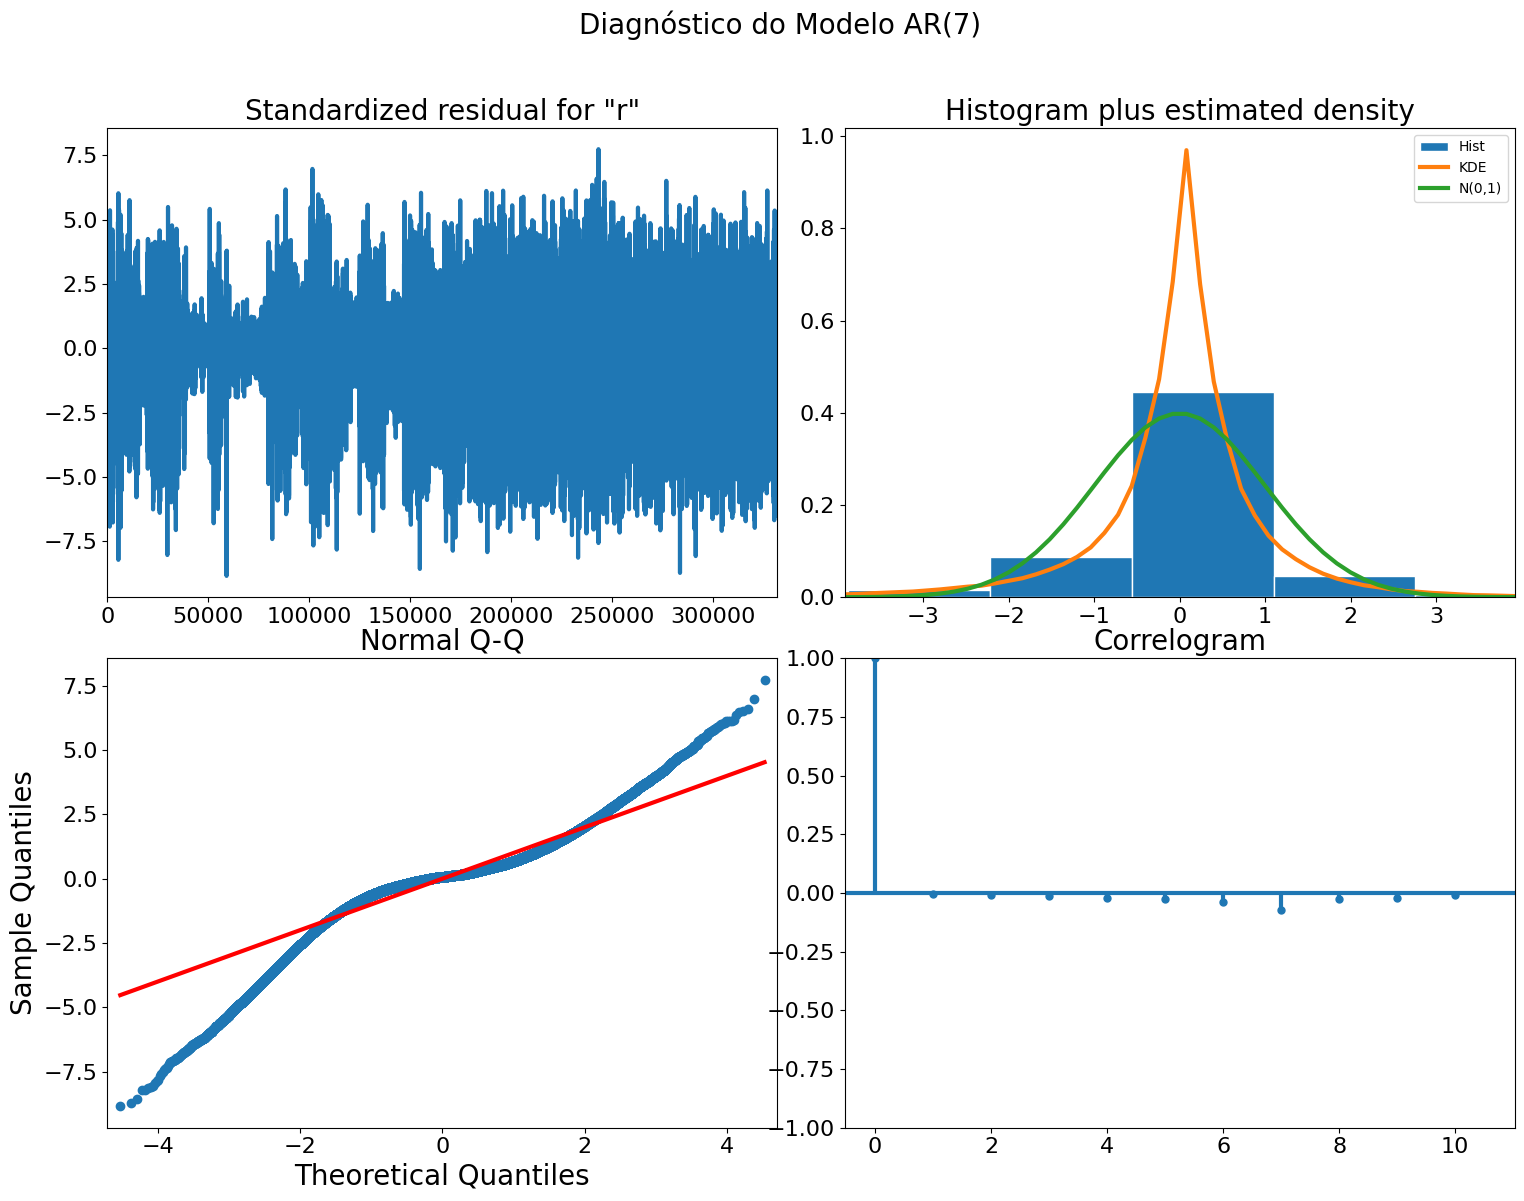


  Analisando Modelo AR(8) / ARIMA(8, 0, 0)

--- Métricas de Avaliação ---
AIC: 1508523.47
BIC: 1508630.60
--- Gráfico de Diagnóstico para AR(8) ---


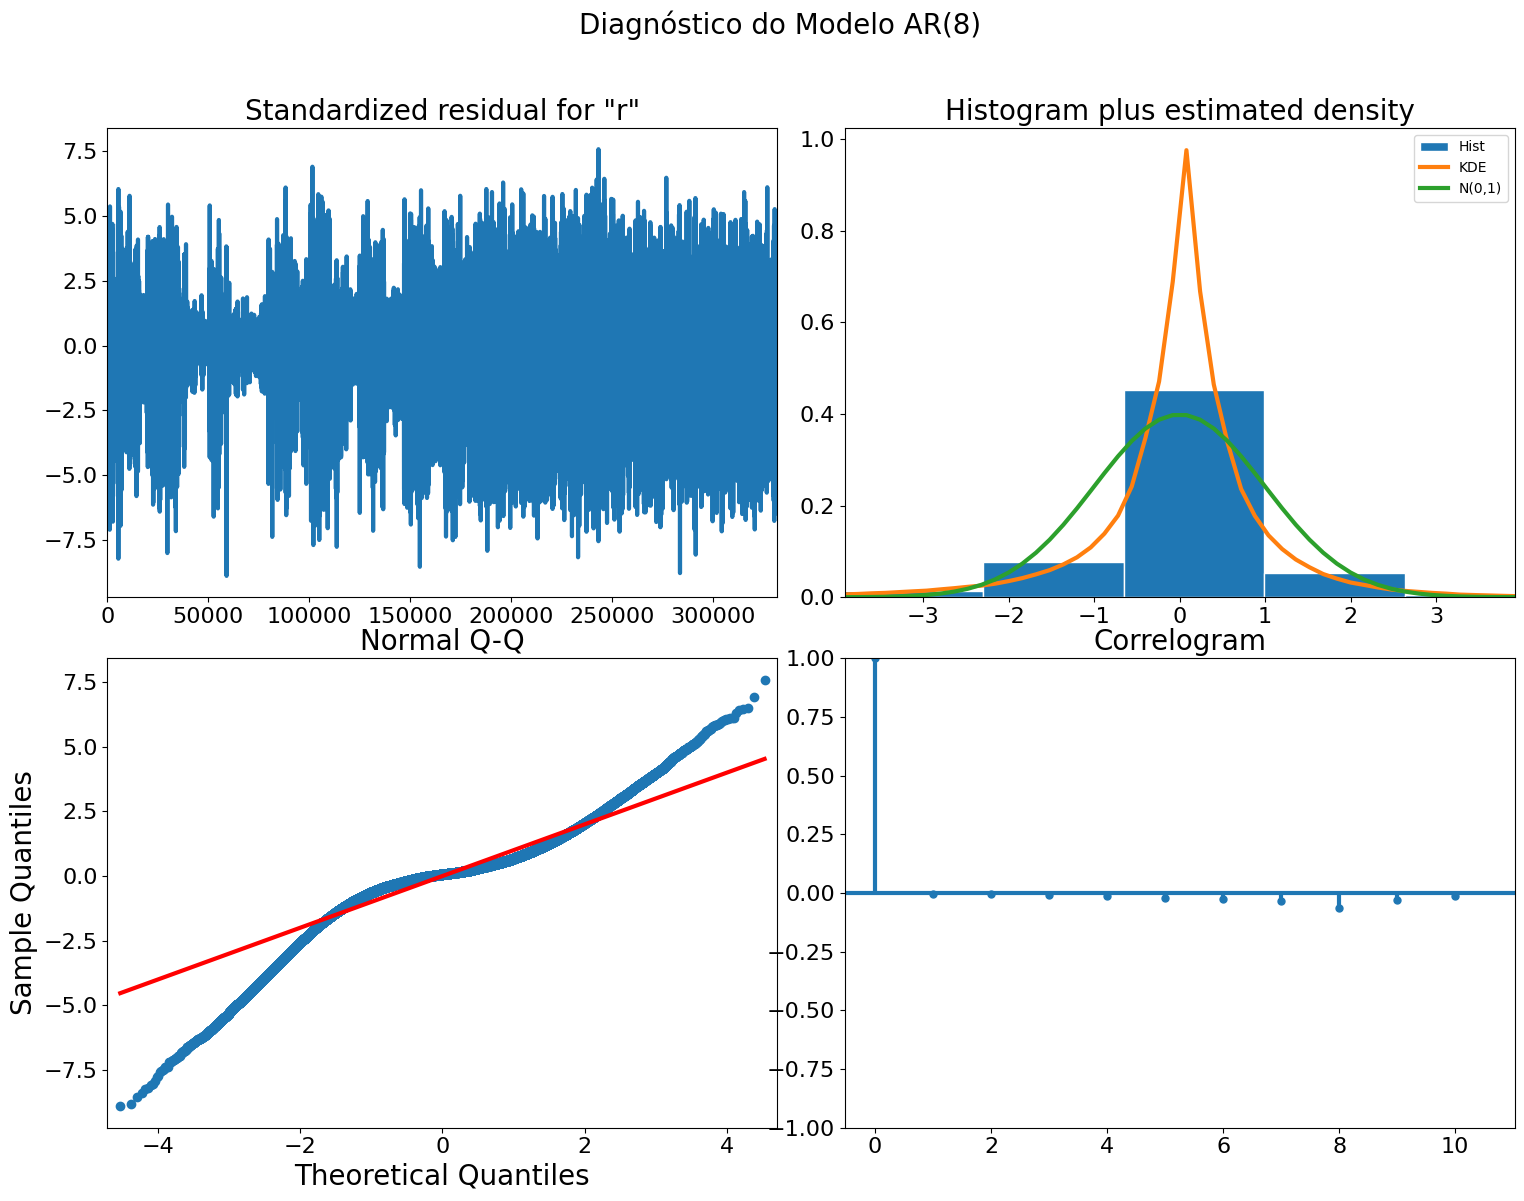

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams['lines.linewidth'] = 3

# Monta o drive e carrega os dados
try:
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/MyDrive/Colab_Datasets/data_5599.csv'
    df_full = pd.read_csv(file_path)
    # Processa os dados
    df_full['node_id'] = '5599'
    df_full['datetime'] = pd.to_datetime(df_full['day'] + ' ' + df_full['hour'], errors='coerce')
    id_vars = ['datetime', 'pkt_number', 'pkt_retry', 'node_id']
    value_vars_rssi = ['fsk_rssi', 'oqpsk_rssi', 'ofdm_rssi']
    df_processed = df_full.melt(
        id_vars=id_vars,
        value_vars=value_vars_rssi,
        var_name='modulation',
        value_name='rssi'
    )
    df_processed['modulation'] = df_processed['modulation'].str.replace('_rssi', '')
    df_case_study = df_processed[df_processed['modulation'] == 'fsk'].copy()
    df_case_study.dropna(subset=['rssi', 'datetime'], inplace=True)
    df_case_study.sort_values('datetime', inplace=True)
    rssi_data = df_case_study['rssi'].reset_index(drop=True)

except Exception as e:
    print(f"Ocorreu um erro: {e}")

# Cria uma função para análise ARMA
def analisar_modelo_ar(p_order, data):
    print(f"\n=======================================================")
    print(f"  Analisando Modelo AR({p_order}) / ARIMA({p_order}, 0, 0)")
    print(f"=======================================================")

    # Ajuste do modelo ARMA
    model = ARIMA(data, order=(p_order, 0, 0))
    results = model.fit()

    # Teste de Ljung-Box
    lb_df = acorr_ljungbox(results.resid, lags=[10], return_df=True)
    ljung_box_pval = lb_df['lb_pvalue'].iloc[0]
    print(f"\n--- Métricas de Avaliação ---")
    print(f"AIC: {results.aic:.2f}")
    print(f"BIC: {results.bic:.2f}")

    # Gráfico de Diagnóstico
    print(f"--- Gráfico de Diagnóstico para AR({p_order}) ---")
    fig = results.plot_diagnostics(figsize=(15, 12))
    fig.suptitle(f'Diagnóstico do Modelo AR({p_order})', fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # Aumenta as fontes dos xticks e yticks
    for ax in fig.axes:
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.title.set_size(20)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)


    plt.show()

# Executa a análise para diferentes ordens
ordens_para_testar = [1, 2, 3, 4, 5, 6, 7, 8]
for p in ordens_para_testar:
    analisar_modelo_ar(p, rssi_data)

# PLOT DA SAÍDA PARA DIVERSOS ARs:

Mounted at /content/drive


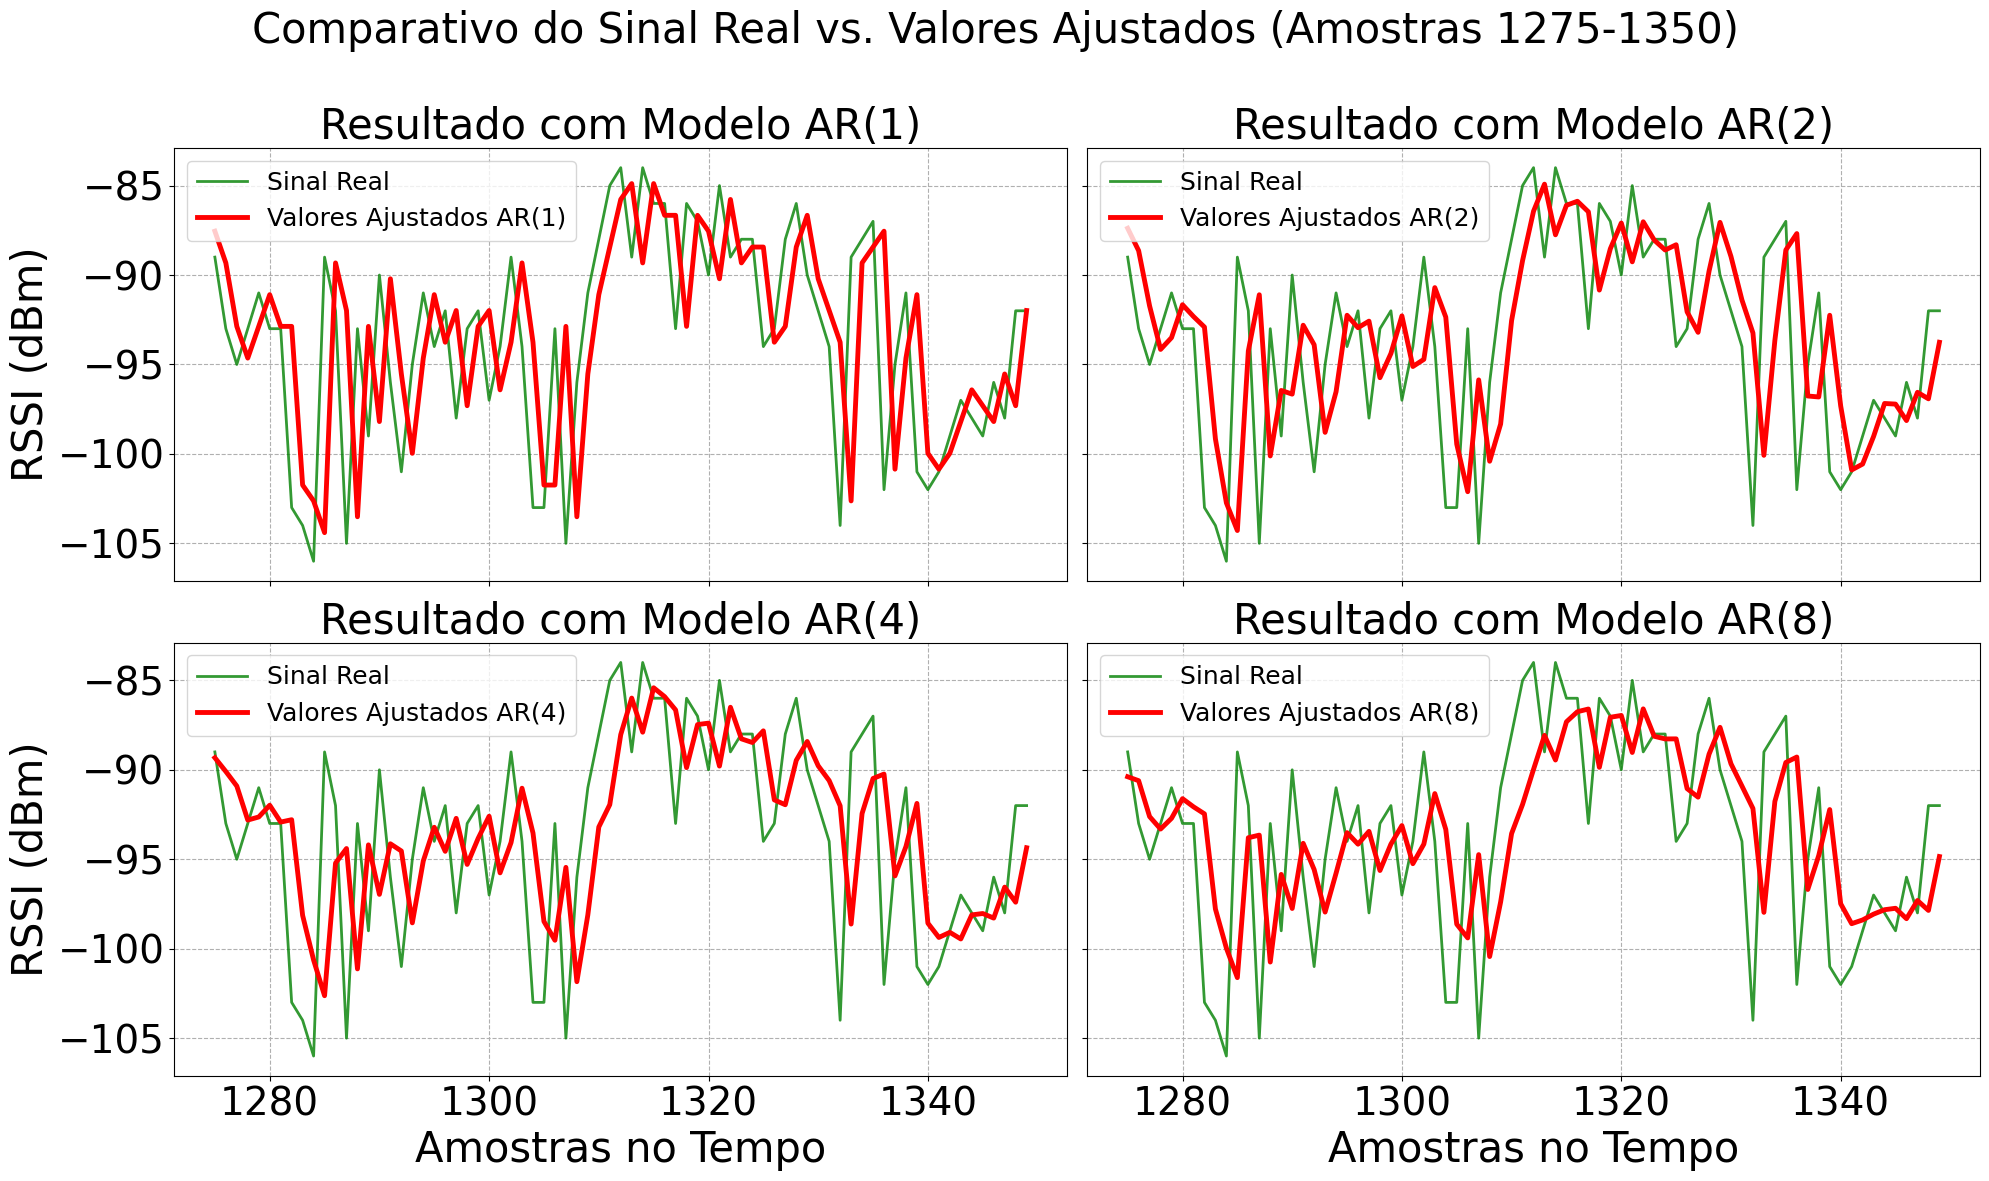

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.arima.model import ARIMA

# Monta o drive e carrega os dados
try:
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/MyDrive/Colab_Datasets/data_5599.csv'
    df_full = pd.read_csv(file_path)
    # Processar os dados
    df_full['node_id'] = '5599'
    df_full['datetime'] = pd.to_datetime(df_full['day'] + ' ' + df_full['hour'], errors='coerce')
    id_vars = ['datetime', 'pkt_number', 'pkt_retry', 'node_id']
    value_vars_rssi = ['fsk_rssi', 'oqpsk_rssi', 'ofdm_rssi']
    df_processed = df_full.melt(
        id_vars=id_vars,
        value_vars=value_vars_rssi,
        var_name='modulation',
        value_name='rssi'
    )
    df_processed['modulation'] = df_processed['modulation'].str.replace('_rssi', '')
    df_case_study = df_processed[df_processed['modulation'] == 'fsk'].copy()
    df_case_study.dropna(subset=['rssi', 'datetime'], inplace=True)
    df_case_study.sort_values('datetime', inplace=True)
    rssi_data = df_case_study['rssi'].reset_index(drop=True)

except Exception as e:
    print(f"Ocorreu um erro: {e}")

# Iterar, modelar e armazenar os valores ajustados
ordens_para_testar = [1, 2, 4, 8]
fitted_signals = {}

for p in ordens_para_testar:
    model = ARIMA(rssi_data, order=(p, 0, 0))
    results = model.fit()
    fitted_signals[f'AR({p})'] = results.fittedvalues

# Define a janela de tempo de interesse
start_index = 1275
end_index = 1350

original_sample = rssi_data.iloc[start_index:end_index]

# Cria uma grade de subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle(f'Comparativo do Sinal Real vs. Valores Ajustados (Amostras {start_index}-{end_index})', fontsize=30)

cores = {'AR(1)': 'red', 'AR(2)': 'red', 'AR(4)': 'red', 'AR(8)': 'red'}
axes = axes.flatten()

# Loop para criar cada um dos quatro gráficos
for i, p_order_str in enumerate(fitted_signals.keys()):
    ax = axes[i]
    fitted_data = fitted_signals[p_order_str]
    fitted_sample = fitted_data.iloc[start_index:end_index]
    ax.plot(original_sample.index, original_sample, color='green', alpha=0.8, linewidth=2.0, label='Sinal Real')
    ax.plot(fitted_sample.index, fitted_sample, color=cores[p_order_str], linewidth=3.5, label=f'Valores Ajustados {p_order_str}')
    ax.set_title(f'Resultado com Modelo {p_order_str}', fontsize=30)
    ax.grid(True, which='both', linestyle='--')
    ax.legend(fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=28)

axes[0].set_ylabel('RSSI (dBm)', fontsize=30)
axes[2].set_ylabel('RSSI (dBm)', fontsize=30)
axes[2].set_xlabel('Amostras no Tempo', fontsize=30)
axes[3].set_xlabel('Amostras no Tempo', fontsize=30)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# SINAL SINTÉTICO:

Mounted at /content/drive
Arquivo carregado com sucesso pelo Google Drive.
Dados preparados para a análise.

--- Ajustando o Modelo AR(8) para obter os parâmetros do sistema ---


/tmp/ipython-input-589459125.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rssi_mean = results.params[0]


Parâmetros do sistema extraídos com sucesso.

--- Gerando o sinal de entrada (Ruído Branco) ---
Sinal de Ruído Branco gerado.

--- Aplicando o sistema AR(8) ao Ruído Branco ---
Sinal de saída do sistema gerado com sucesso.

--- Gerando o gráfico de comparação: Sinal Real vs. Saída do Sistema ---


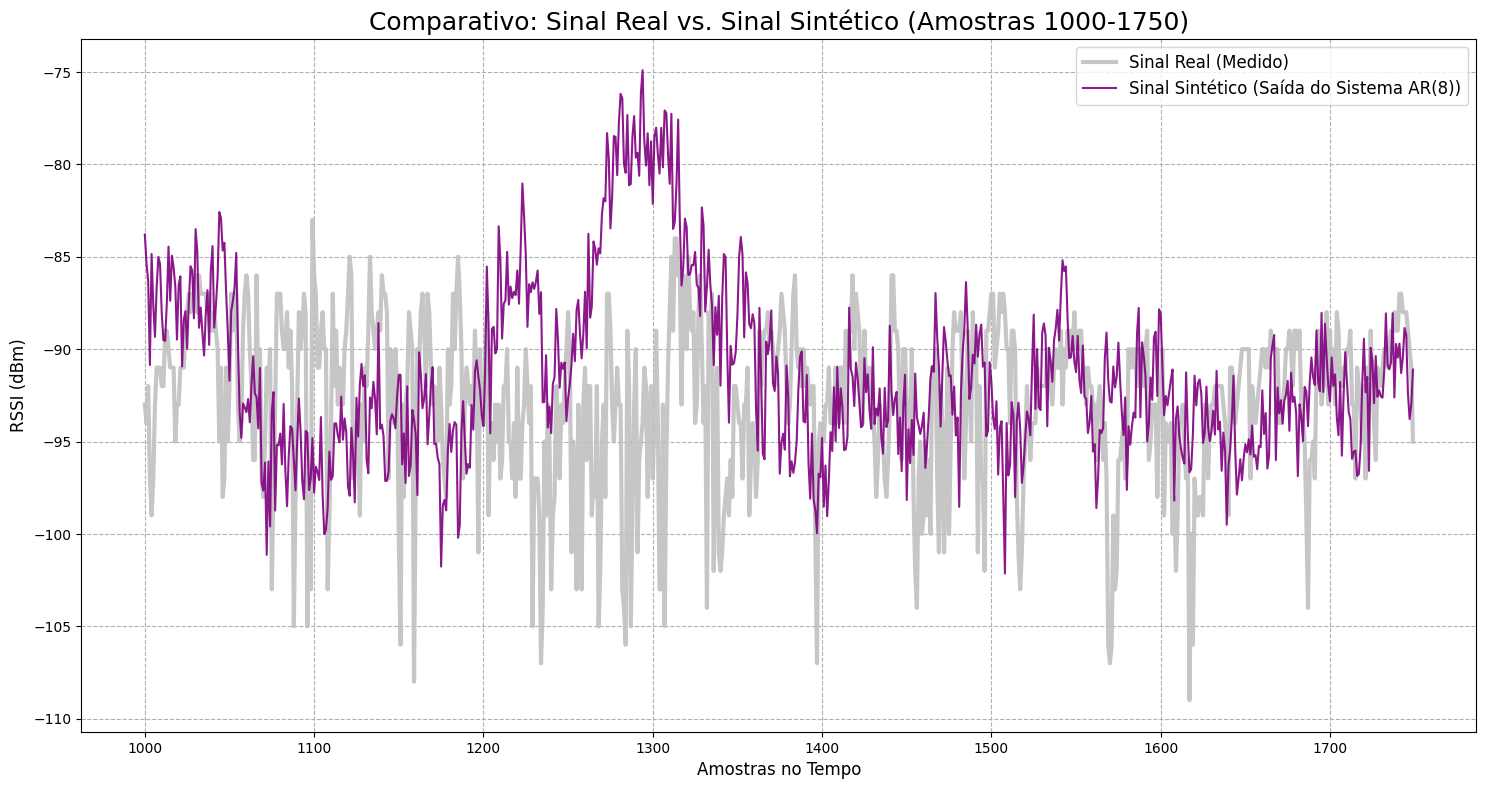

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import lfilter

# Montar o Drive e carregar os dados
try:
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/MyDrive/Colab_Datasets/data_5599.csv'
    df_full = pd.read_csv(file_path)
    print("Arquivo carregado com sucesso pelo Google Drive.")

    # Processar os dados
    df_full['node_id'] = '5599'
    df_full['datetime'] = pd.to_datetime(df_full['day'] + ' ' + df_full['hour'], errors='coerce')
    id_vars = ['datetime', 'pkt_number', 'pkt_retry', 'node_id']
    value_vars_rssi = ['fsk_rssi', 'oqpsk_rssi', 'ofdm_rssi']
    df_processed = df_full.melt(
        id_vars=id_vars,
        value_vars=value_vars_rssi,
        var_name='modulation',
        value_name='rssi'
    )
    df_processed['modulation'] = df_processed['modulation'].str.replace('_rssi', '')
    df_case_study = df_processed[df_processed['modulation'] == 'fsk'].copy()
    df_case_study.dropna(subset=['rssi', 'datetime'], inplace=True)
    rssi_data = df_case_study['rssi'].reset_index(drop=True)
    print("Dados preparados para a análise.\n")

except Exception as e:
    print(f"Ocorreu um erro: {e}")

# Ajustar o modelo AR(8) original para obter os parâmetros do sistema
print("--- Ajustando o Modelo AR(8) para obter os parâmetros do sistema ---")
original_model = ARIMA(rssi_data, order=(8, 0, 0))
results = original_model.fit()
ar_coefficients = results.params[1:9]
rssi_mean = results.params[0]
noise_variance = np.var(results.resid)
n_samples = len(rssi_data)
print("Parâmetros do sistema extraídos com sucesso.\n")

# Gerar um sinal de entrada de Ruído Branco Gaussiano
print("--- Gerando o sinal de entrada (Ruído Branco) ---")
noise_std_dev = np.sqrt(noise_variance)
white_noise_input = np.random.normal(loc=0, scale=noise_std_dev, size=n_samples)
print("Sinal de Ruído Branco gerado.\n")

# Aplicar o sistema AR(8) ao sinal de Ruído Branco para gerar a saída
print("--- Aplicando o sistema AR(8) ao Ruído Branco ---")
a_coeffs = np.concatenate(([1], -ar_coefficients))
b_coeffs = [1]
ar_output_centered = lfilter(b_coeffs, a_coeffs, white_noise_input)
synthetic_ar8_signal = ar_output_centered + rssi_mean
print("Sinal de saída do sistema gerado com sucesso.\n")

# Plotar a comparação final
print("--- Gerando o gráfico de comparação: Sinal Real vs. Saída do Sistema ---")

# Define a janela de tempo de interesse
start_index = 1000
end_index = 1750

# Seleciona as fatias de dados para plotagem
real_signal_sample = rssi_data.iloc[start_index:end_index]
system_output_sample = synthetic_ar8_signal[start_index:end_index]

plt.figure(figsize=(18, 9))

# Plota as duas séries no mesmo gráfico
plt.plot(real_signal_sample.index, real_signal_sample, color='silver', alpha=0.9, label='Sinal Real (Medido)')
plt.plot(real_signal_sample.index, system_output_sample, color='purple', linewidth=1.5, alpha=0.9, label='Sinal Sintético (Saída do Sistema AR(8))')

plt.title(f'Comparativo: Sinal Real vs. Sinal Sintético (Amostras {start_index}-{end_index})', fontsize=18)
plt.xlabel('Amostras no Tempo', fontsize=12)
plt.ylabel('RSSI (dBm)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--')
plt.show()